## **라이브러리 다운로드 및 불러오기**

In [ ]:
## 라이브러리 다운로드

# 통계
!pip3 install numpy scipy patsy pandas

# 한글깨짐 해결('코드 실행' → '런타임' → '세션 다시시작' 실행)
!pip install matplotlib -U
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 워드클라우드
!pip install nltk
!pip install wordcloud
!pip install konlpy

# 연관성분석
!pip install apyori

In [ ]:
## 라이브러리 불러오기

# 데이터 핸들링
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import re

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False  # plot "-" 부호 표기 설정

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# 통계
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from apyori import apriori
import networkx as nx

# NLP
import nltk
from wordcloud import WordCloud

# 경고 안내 무시
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## 함수 생성

# 시각화 옵션 정의
def plot_option01():
    plt.rc('font', family='NanumBarunGothic')               # 폰트 설정
    plt.xticks(size = 10, fontweight ="bold")               # x축 크기 및 폰트 굵기 설정
    plt.yticks(size = 10, fontweight ="bold")               # y축 크기 및 폰트 굵기 설정

# 시각화 차트 정의
def make_plot01(plot_name, plot_xlabel, plot_ylabel, data01):
    get_data = data01.value_counts().sort_index(ascending=False)

    plot_option01()                                         # 시각화 옵션 함수
    get_data.plot(kind='bar', color='k', alpha = 0.8)       # 시각화 출력

    plt.title(plot_name, fontsize=12, fontweight ="bold")   # 차트 이름
    plt.xlabel(plot_xlabel, fontweight='bold')              # x축 이름
    plt.ylabel(plot_ylabel, fontweight='bold')              # y축 이름
    plt.xticks(rotation=90)                                 # x축 이름 방향설정
    plt.grid(False)                                         # 차트 선 제거

## **데이터**

In [ ]:
# 데이터 불러오기
MDunpa_df04 = pd.read_csv('/content/drive/MyDrive/3. Research/[기업] 분석 과제/네오플 트렌드 분석/Data/Fianl_Review_Dataset_04.csv')

# 데이터 전처리
MDunpa_df04 = MDunpa_df04[MDunpa_df04["filtering"]!="불일치"]                                                                           # 불필요한 데이터 제거(상반되는 극단치 제거)
MDunpa_df04 = MDunpa_df04.reset_index()                                                                                                 # 인덱스 초기화
MDunpa_df04["작성일자"] = pd.to_datetime(MDunpa_df04["작성일자"])                                                                       # 데이터 타입 변환
del MDunpa_df04["Unnamed: 0"]; del MDunpa_df04["index"]                                                                                 # 불필요 변수 제거

# 데이터 확인
print(MDunpa_df04.shape)
MDunpa_df04.tail()

(10653, 18)


,리뷰_ID,고객_ID,평점,평점극성,감성점수,감성극성,유용성,(원본)리뷰어,(정제)리뷰어,품사(빈도),품사(감성),작성일자,년,월,일,Binary,filtering,감정
10648,11662,ᄌᄒ,1,부정,0,중립,1,1주년이 뭔 주는게 저번 레압뿌리는거만도못함 그리고 오즈마 횟수는 왜갑자기 증발하는...,주년이 뭔 주는 게 저번레 압뿌리는 거만도 못함 그리고 오즈마 횟수는 왜 갑자기 증...,"['주년', '게', '저번', '레', '압', '거만', '오즈', '마', '...","['주년', '주는', '저번', '뿌리는', '거만', '오즈', '횟수', '갑...",2023-04-04,2023,4,4,After,일치,혐오
10649,11663,YU k,3,중립,0,중립,1,사람이 너무 많이 줄었음;; '그 국가'에 정식출시하는 것 말곤 답이 없는 듯,사람이 너무 많이 줄었음 그 국가에 정식 출시하는 것 말곤답이 없는 듯,"['사람', '그', '국가', '정식', '출시', '것', '답', '듯']","['사람', '너무', '많이', '줄었음', '국가', '정식', '출시', '하...",2023-04-04,2023,4,4,After,일치,중립
10650,11664,장정현,1,부정,-1,부정,1,생각이 있다면 버서커 너프좀 하시길,생각이 있다면 버서 커너프 좀 하시길,"['생각', '버', '너프', '좀']","['생각', '있다면', '너프', '하시길']",2023-04-04,2023,4,4,After,일치,혐오
10651,11665,Eddie park,3,중립,3,긍정,1,오래전 피던에대한 추억 향수으로 잘하고 있지만 이벤트도 너무 숙제같아지고 있고 신규...,오래전 피던 에 대한 추억 향수으로 잘하고 있지만 이벤트도 너무 숙제 같아지고 있고...,"['대한', '추억', '향수', '로', '이벤트', '숙제', '신규', '케릭...","['오래전', '피던', '대한', '추억', '향수', '하고', '있지만', '...",2023-04-05,2023,4,5,After,일치,슬픔
10652,11666,롤롤,5,긍정,0,중립,0,아라드격투왕 터치안되는버그 빨리 고쳐주시고 접속하면 아이템 없다고 뜨는 버그 고쳐줘요,아라드격투왕 터치 안 되는 버그빨리 고쳐주시고 접속하면 아이템 없다고 뜨는 버그 고쳐줘요,"['아라드', '격투', '터치', '안', '버그', '접속', '아이템', '버그']","['아라드', '격투', '터치', '되는', '버그', '빨리', '고쳐주시고',...",2023-04-05,2023,4,5,After,일치,중립


## **데이터 EDA**

In [ ]:
## 전체 데이터
print(len(MDunpa_df04))                                                         # (전체) 리뷰 데이터 수
print(round(MDunpa_df04["평점"].mean(), 2));print()                             # (전체) 평점 평균값

before_MDunpa_df04 = MDunpa_df04[MDunpa_df04["Binary"]=="Befor"]                # 작성일자: 22.03.22~22.10.14
print(len(before_MDunpa_df04))                                                  # (KGA대상 전) 리뷰 데이터 수
print(round(before_MDunpa_df04["평점"].mean(), 2));print()                      # (KGA대상 전) 평점 평균값

after_MDunpa_df04 = MDunpa_df04[MDunpa_df04["Binary"]=="After"]                 # 작성일자: 22.10.16~23.04.05
print(len(after_MDunpa_df04))                                                   # (KGA대상 후) 리뷰 데이터 수
print(round(after_MDunpa_df04["평점"].mean(), 2))                               # (KGA대상 후) 평점 평균값

10653
3.71

9883
3.78

770
2.84


In [ ]:
# (전체) 평점 요인별 데이터 확인
MDunpa_df04["평점"].value_counts().sort_index(ascending=False)

,count
평점,
5,5821
4,1125
3,938
2,359
1,2410


### **상관분석**

In [ ]:
# 데이터 타입 변환
MDunpa_df04 = MDunpa_df04.astype("str")
MDunpa_df04 = MDunpa_df04.astype({'평점': 'int', '감성점수': 'int',  '유용성': 'int'})
MDunpa_df04["작성일자"] = pd.to_datetime(MDunpa_df04["작성일자"])

In [ ]:
# 데이터 기초통계값 확인
MDunpa_df04[['리뷰_ID', '고객_ID', '평점', '평점극성', '감성점수', '감성극성', '유용성', '작성일자', 'Binary', 'filtering', '감정']].describe(include='all')

,리뷰_ID,고객_ID,평점,평점극성,감성점수,감성극성,유용성,작성일자,Binary,filtering,감정
count,10653,10653,10653.0000,10653,10653.0000,10653,10653.0000,10653,10653,10653,10653
unique,10653,9742,NaN,3,NaN,3,NaN,NaN,2,1,7
top,0,Google 사용자,NaN,긍정,NaN,중립,NaN,NaN,Befor,일치,행복
freq,1,16,NaN,6946,NaN,7984,NaN,NaN,9883,10653,4497
mean,NaN,NaN,3.7123,NaN,0.1783,NaN,1.1478,2022-04-27 11:46:57.347226112,NaN,NaN,NaN
min,NaN,NaN,1.0000,NaN,-8.0000,NaN,0.0000,2022-03-22 00:00:00,NaN,NaN,NaN
25%,NaN,NaN,2.0000,NaN,0.0000,NaN,0.0000,2022-03-24 00:00:00,NaN,NaN,NaN
50%,NaN,NaN,5.0000,NaN,0.0000,NaN,0.0000,2022-03-25 00:00:00,NaN,NaN,NaN
75%,NaN,NaN,5.0000,NaN,0.0000,NaN,0.0000,2022-04-09 00:00:00,NaN,NaN,NaN
max,NaN,NaN,5.0000,NaN,13.0000,NaN,1070.0000,2023-04-05 00:00:00,NaN,NaN,NaN


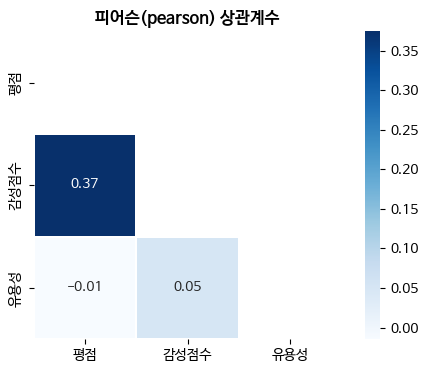

In [ ]:
## 피어슨 상관분석(정규분포임을 가정하는 모수적 추론 방법)

conti_vari01 = MDunpa_df04[["평점", "감성점수", "유용성"]]              # 연속형 변수만 선별
pearson_correlation_matrix = conti_vari01.corr(method='pearson')        # 연속형 변수 간 상관정도 추론

# 시각화
mask = np.zeros_like(pearson_correlation_matrix.corr()); mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(pearson_correlation_matrix, cbar = True, mask=mask, annot=True,  annot_kws={'size' : 10}, fmt = '.2f', square=True, cmap='Blues', linewidths=0.01, linecolor='white')

# 차트 옵션 설정
plt.title("피어슨(pearson) 상관계수", fontsize=12, fontweight ="bold")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams['font.family'] = 'NanumBarunGothic'

In [ ]:
# 상기 상관분석을 통해 '감성점수'과 '평점' 간에 뚜렷한 양적 관계를 갖는 것을 확인 完 / 반면, 이 외 변수는 특별한 관계를 갖지 않는 것을 확인 完
# 해당 결과는 사전에 수행한 '극단치 제거' 과정으로 인한 것이라 판단됨

### **군집분석**

In [ ]:
conti_vari01.tail()

,평점,감성점수,유용성
10648,1,0,1
10649,3,0,1
10650,1,-1,1
10651,3,3,1
10652,5,0,0


In [ ]:
pca = PCA(n_components=2)
reduced_df = pca.fit_transform(conti_vari01)
reduced_df.shape

(10653, 2)

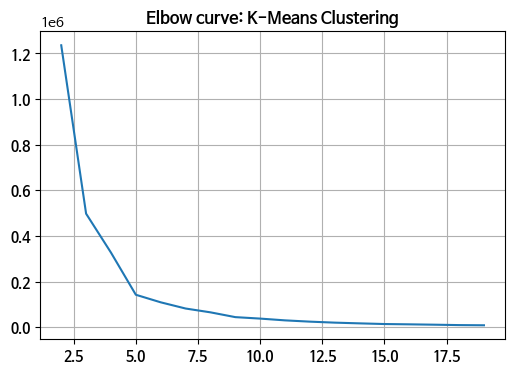

In [ ]:
## Elbow curve분석
# KMeans모델을 사용하기 위한 최적의 K값 측정

# 모델 정의
distortions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)            # KMeans모델 정의
    kmeans.fit(reduced_df)                   # KMeans모델 학습
    distortions.append(kmeans.inertia_)      # inertia value 측정(군집 데이터 간 거리를 합산한 값)

# 시각화
plt.title('Elbow curve: K-Means Clustering', fontsize=12, fontweight='bold')
plt.grid(True)
plot_option01()
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(range(2, 20), distortions)
plt.show()

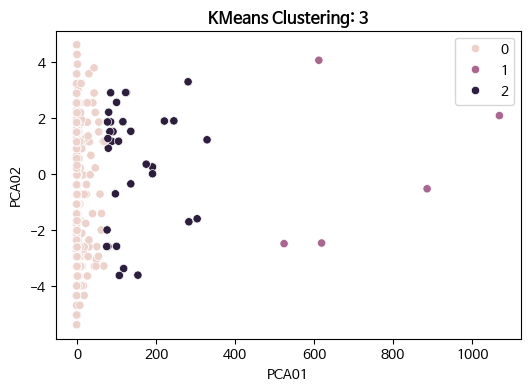

k( 3 )실루엣 계수(Silhouette Coefficient): 0.9809
k( 3 )데이비스 볼딘 지수(Davies Bouldin Index): 0.4211



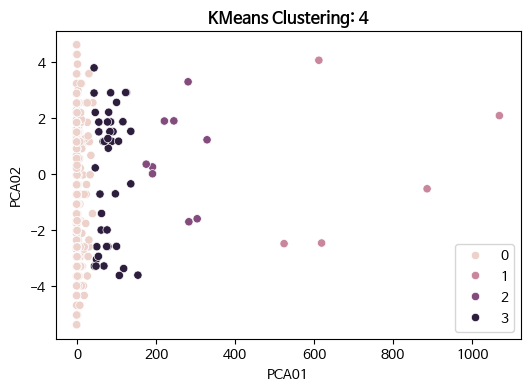

k( 4 )실루엣 계수(Silhouette Coefficient): 0.9711
k( 4 )데이비스 볼딘 지수(Davies Bouldin Index): 0.4222



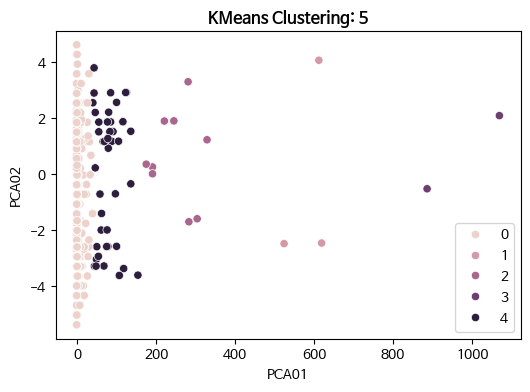

k( 5 )실루엣 계수(Silhouette Coefficient): 0.9709
k( 5 )데이비스 볼딘 지수(Davies Bouldin Index): 0.3693



In [ ]:
reduced_df = pd.DataFrame(reduced_df)

eps = [3, 4, 5]
for i in eps:
  km = KMeans(n_clusters = i, init='k-means++')
  cluster = km.fit(reduced_df)
  cluster_id = pd.DataFrame(cluster.labels_)
  datadf = pd.concat([reduced_df, cluster_id], axis=1)
  datadf.columns = ["PCA01", "PCA02", "cluster"]

  # 군집분석한 결과의 3개 경우를 가져오고자 조건문 설정(군집에 따른 인사이트 도출)
  if i == 3:
    datadf_03 = datadf["cluster"]
  elif i == 4:
    datadf_04 = datadf["cluster"]
  else:
    datadf_05 = datadf["cluster"]

  sns.scatterplot(x = "PCA01",  y = "PCA02", data = datadf, hue = datadf['cluster'], legend="full")
  plt.title('KMeans Clustering: {:.0f}'.format(i), fontsize=12, fontweight='bold')
  plt.legend()
  plt.show()

  print('k(', i, ')실루엣 계수(Silhouette Coefficient): {:.4f}'.format(metrics.silhouette_score(datadf.iloc[:,:-1], datadf['cluster'])))
  print('k(', i, ')데이비스 볼딘 지수(Davies Bouldin Index): {:.4f}'.format(metrics.davies_bouldin_score(datadf.iloc[:,:-1], datadf['cluster']))); print()

In [ ]:
datadf

,PCA01,PCA02,cluster
0,-1.1500,1.1457,0
1,-1.1472,1.4925,0
2,-1.1444,1.8394,0
3,87.8496,1.1660,4
4,-1.1500,1.1457,0
...,...,...,...
10648,-0.1449,-2.6058,0
10649,-0.1474,-0.7299,0
10650,-0.1477,-2.9526,0
10651,-0.1390,0.3106,0


In [ ]:
## 유저를 군집분석해보고자 KMeans모델을 활용했으며, 최적의 K값을 측정하고자, ①실루엣 계수, ②데이비스 볼딘 지수, ③엘보우 곡선 지표를 사용했다.
# ①실루엣 계수: -1부터 1사이 값으로 구성되어, 1에 가까울수록 최적화된 군집이라 해석 가능
# ②데이비스 볼딘 지수: 다른 그룹 간의 분리 정도를 비율로 나타낸 것으로 값이 작을수록 최적화되었다 해석 가능
# ③엘보우 곡선: 군잡 간 거리 합을 나타내는 inertia가 급락하는 구간이 생기는데, 이 지점을 군집 수로 활용하는 방법(즉,  꺾이는 구간 활용)

In [ ]:
## 상기 KMeans모델의 최적의 K값을 측정하여, 3개 혹은 5개가 적절하다는 것을 확인 完
## 여기서, 데이터 수가 적다는 점을 고려했을 때 많은 고객 유형으로 분류하는 것은 적절한 접근이 아니라 판단되어 3개 군집을 활용한다.

# 실루엣계수: 3개
# 데이비드볼릿: 5개
# 엘보우 곡선: 3개 혹은 5개

In [ ]:
MDunpa_df04["cluster_03"] = datadf_03
MDunpa_df04["cluster_04"] = datadf_04
MDunpa_df04["cluster_05"] = datadf_05

### **시각화 분석**

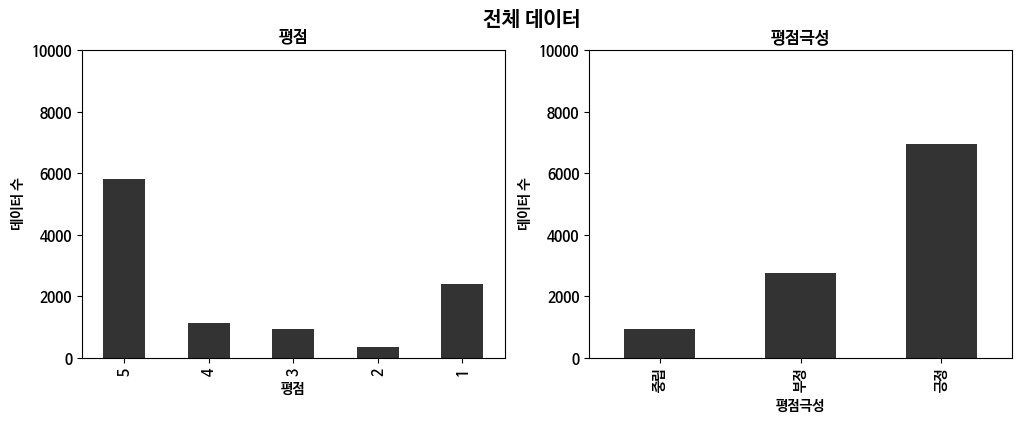

In [ ]:
## 시각화

# 차트 옵션 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams["figure.figsize"] = (12,4)
plt.suptitle('전체 데이터', fontsize=15, fontweight ="bold")

# 평점 시각화
plt.subplot(1, 2, 1)
make_plot01("평점", "평점", "데이터 수", MDunpa_df04["평점"])
plt.rcParams["figure.figsize"] = (6, 3); plt.ylim([0, 10000])

# 평점극성 시각화
plt.subplot(1, 2, 2)
make_plot01("평점극성", "평점극성", "데이터 수", MDunpa_df04["평점극성"])
plt.rcParams["figure.figsize"] = (6, 3); plt.ylim([0, 10000])
plt.show()

In [ ]:
# 전체 데이터의 '평점'을 확인한 결과, 양극단의 값(1점과 5점)이 많고 전반적으로 긍정적인 리뷰가 많음을 확인 完

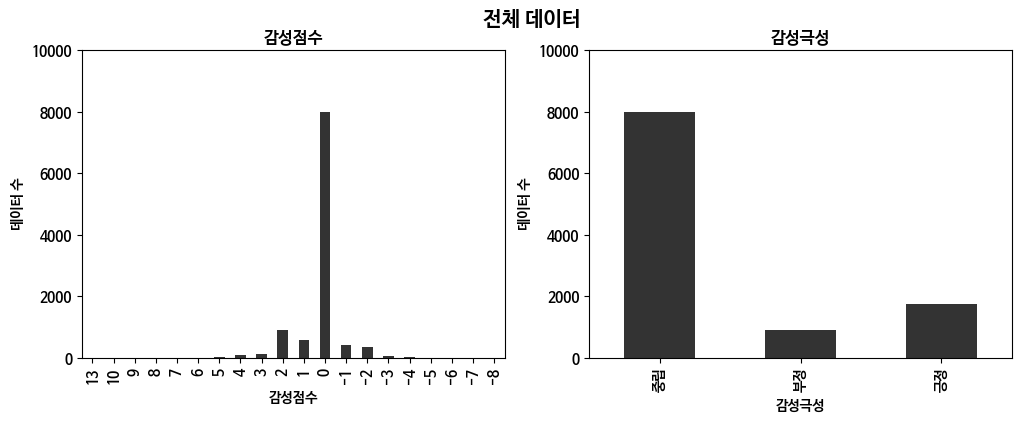

In [ ]:
# 시각화: 감성점수 및 감성극성

plt.rc('font', family='NanumBarunGothic'); plt.rcParams["figure.figsize"] = (12,4)
plt.suptitle('전체 데이터', fontsize=15, fontweight ="bold")

plt.subplot(1, 2, 1)
make_plot01("감성점수", "감성점수", "데이터 수", MDunpa_df04["감성점수"])
plt.rcParams["figure.figsize"] = (6, 3); plt.ylim([0, 10000])

plt.subplot(1, 2, 2)
make_plot01("감성극성", "감성극성", "데이터 수", MDunpa_df04["감성극성"])
plt.rcParams["figure.figsize"] = (6, 3); plt.ylim([0, 10000])
plt.show()

In [ ]:
# 전체 데이터의 '평성점수'를 확인한 결과, 0점을 제외하고 양의 값이 많고 전반적으로 중립적 상태임을 확인 完

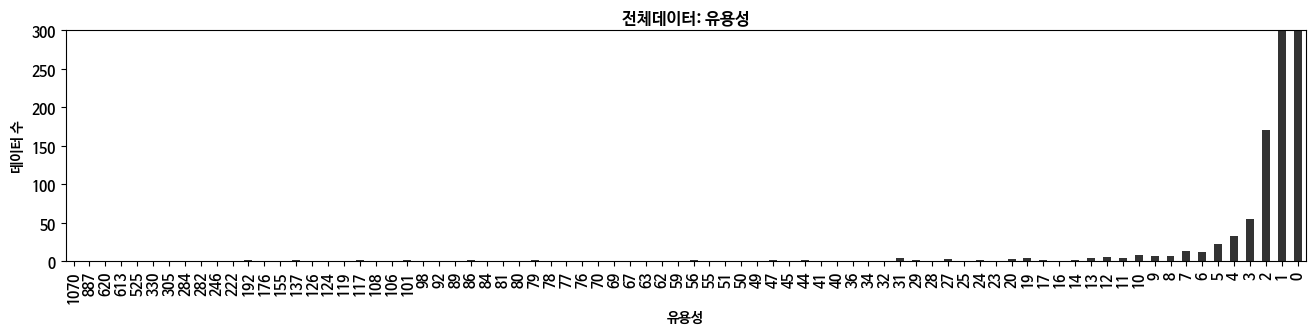

,count
유용성,
0,9464
1,761
2,170
3,55
4,33


In [ ]:
# 시각화
make_plot01("전체데이터: 유용성", "유용성", "데이터 수", MDunpa_df04["유용성"])
plt.rcParams["figure.figsize"] = (16, 3); plt.ylim([0, 300])
plt.show()

MDunpa_df04["유용성"].value_counts().sort_index(ascending=True).head()

In [ ]:
# 전체 데이터의 '유용성'을 확인한 결과, 전반적으로 공감을 얻지 못했지만, 일부 리뷰는 많은 공감을 얻어 해당 리뷰 데이터만을 선별하여 분석해볼 필요가 있다 판단

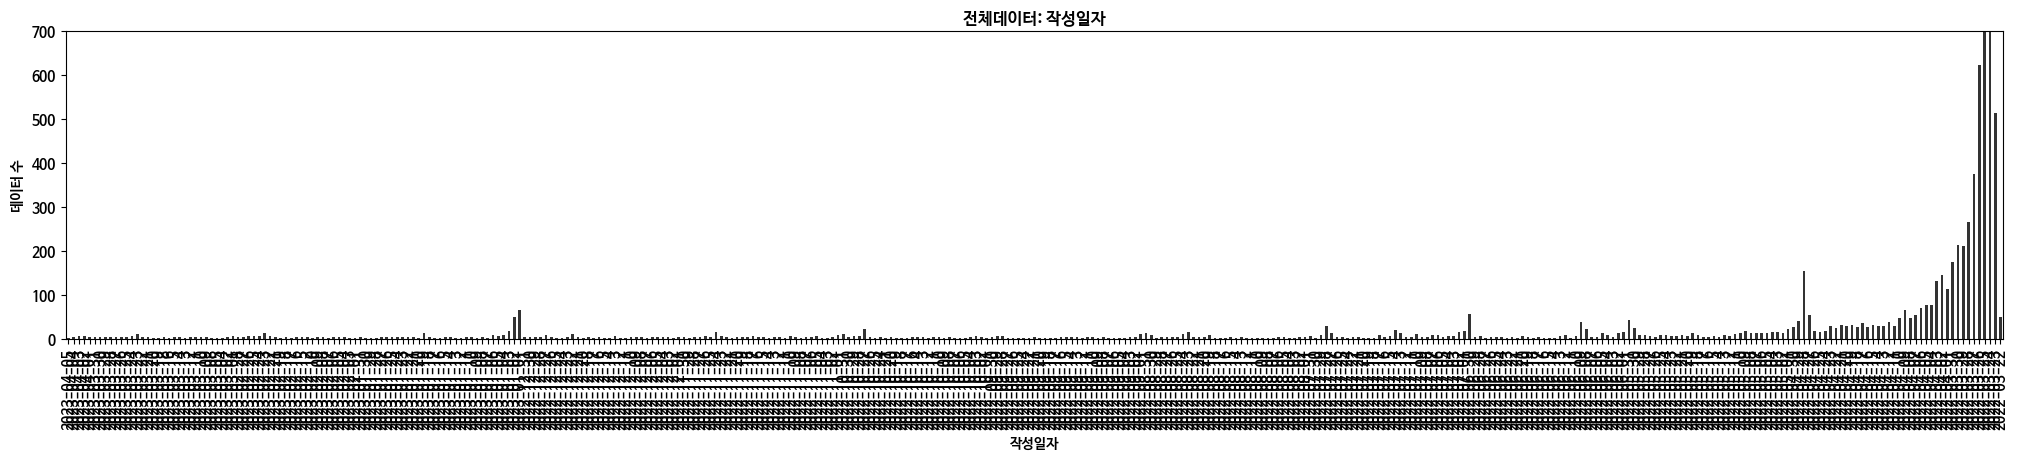

,count
작성일자,
2022-03-22,49
2022-03-23,513
2022-03-24,3251
2022-03-25,1583
2022-03-26,622


In [ ]:
# 시각화: 작성일자

MDunpa_df04["작성일자"] = MDunpa_df04["작성일자"].astype("str")
make_plot01("전체데이터: 작성일자", "작성일자", "데이터 수", MDunpa_df04["작성일자"])
plt.rcParams["figure.figsize"] = (25, 4); plt.ylim([0, 700])
plt.show()

MDunpa_df04["작성일자"].value_counts().sort_index(ascending=True).head()

In [ ]:
# 던전앤파이터 모바일은 22.03.24 오픈했으며, 오픈 당시 리뷰 데이터 수가 가장 많은 것을 확인했다.
# 또한, 정식 오픈 이전 댓글도 존재하는 것으로 보아 게임에 대한 플레이어들의 기대가 높았을 것으로 예상된다.
# 하지만, 당연한 논리지만 플레이 유저들의 관심도는 점차 감소하는 것을 확인했다.
# 단 게임의 주요 업데이트 일에는 고객 리뷰 작성 건수가 증가했으며, 여전히 게임에 대한 관여도가 존재함을 확인했다.

___

### **워드클라우드(빈도분석)**

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
## 워드클라우드(빈도분석)(1)
# '명사' 품사를 추출하여 리스트 형태로 생성

sample_data03_list01 = []
sample_data03_list02 = []

for i in tqdm(range(0, len(MDunpa_df04))):
  sample_data01 = str(str(str(MDunpa_df04["품사(빈도)"][i]).split("[")[1]).split("]")[0])   # (감성분석에서 생성된 품사) '명사' 추출
  sample_data02 = re.sub(r'[\'\"]', '',sample_data01)                                       # 특수문자 제거
  sample_data03 = re.sub(r'\s+', '', sample_data02).split(",")                              # 공백 제거

  for j in range(0, len(sample_data03)):
    text = sample_data03[j]
    if len(text) < 2:          # 글자 수가 0개 혹은 1개일 경우, 비활용
      pass
    else:                      # 글자 수가 2개 이상일 경우 데이터 활용
      sample_data03_list01.append(text)
  sample_data03_list02.append(sample_data03_list01)
  sample_data03_list01 = []

100%|██████████| 10653/10653 [00:00<00:00, 58432.79it/s]


In [ ]:
## 워드클라우드(빈도분석)(2)
# '명사' 품사로 구성된 리스트를 한개 리스트에 삽입하여 리스트 생성

MDunpa_reviews_list = []
for i in tqdm(range(0, len(sample_data03_list02))):
  sample_Data01 = sample_data03_list02[i]
  for j in sample_Data01:
    MDunpa_reviews_list.append(j)

100%|██████████| 10653/10653 [00:00<00:00, 965636.25it/s]


In [ ]:
## 워드클라우드(빈도분석)(3)
# 분석을 위해 1개 글자 수나 불용어사전 단어를 전처리

# 불용어사전 구축(분석 결과를 확인하며, 불필요한 단어를 추가하며 사전 구축)
Stop_Word_dic = ["게임", "모바일", "생각", "던파", "사전", "계속", "진짜", "다시", "그냥", "하라", "다른", "정말", "정도", "시작", "하나", "만큼", "역시", "처음", "구글", "지금", "건가", "해도", "확인", "때문",  "자꾸", "조금", "아주",
                 "해당", "일단", "무슨", "하니", "부분", "이상", "이후", "오늘", "수가", "추가", "바로", "보고", "이건", "이번", "요즘", "이제", "수라", "가지", "뭔가", "발아", "거의", "중이", "가요", "경우", "그때", "던전앤파이터", "차이"]

def count_frequency(my_list):
    count = {}                                     # 불용어사전 정의
    for item in my_list:                           # 불용어사전에 카운팅 측정
      if len(item)<= 1 or item in Stop_Word_dic:   # 필터: ①1개 글자 수, ②불용어사전 단어
        pass
      else:
        count[item] = count.get(item, 0) + 1
    return count

# 전처리 수행 및 결과 확인
MDunpa_reviews_words = count_frequency(MDunpa_reviews_list)                                                           # 토큰 전처리 함수를 통한 Dict형태로 빈도 측정
MDunpa_reviews_words = dict(sorted(MDunpa_reviews_words.items(), key = lambda item: item[1], reverse = True))         # Dict형태로 측정된 결과 정렬
print(MDunpa_reviews_words)

{'추억': 980, '업데이트': 905, '옛날': 615, '접속': 510, '유저': 508, '플레이': 434, '피로': 410, '자동': 329, '결투': 311, '재미': 300, '시간': 292, '예약': 284, '느낌': 257, '삭제': 257, '스킬': 254, '서버': 252, '버전': 251, '과금': 244, '결장': 238, '사람': 237, '등록': 237, '현질': 233, '사냥': 231, '예전': 230, '버그': 219, '패치': 214, '조작': 207, '운영': 205, '문제': 202, '캐릭터': 199, '보상': 187, '리뷰': 181, '그대로': 178, '던전': 175, '밸런스': 173, '쿠폰': 172, '넥슨': 168, '설치': 166, '실행': 164, '캐릭': 155, '파티': 154, '해결': 153, '시스템': 153, '화면': 150, '오류': 150, '감성': 148, '사용': 143, '기대': 140, '피씨': 139, '직업': 136, '새록새록': 135, '네트워크': 134, '유도': 133, '국가': 129, '향수': 128, '진행': 128, '최고': 127, '버튼': 124, '로그인': 122, '아이템': 121, '컨텐츠': 118, '다운': 115, '제한': 111, '에픽': 110, '개선': 109, '초반': 109, '보드': 109, '언제': 108, '데이터': 107, '최신': 103, '업뎃': 102, '출시': 101, '자체': 100, '로딩': 100, '격감': 100, '최적화': 97, '계정': 96, '제발': 95, '중국': 94, '컴퓨터': 94, '오픈': 92, '검사': 92, '아바타': 91, '울트라': 91, '그래픽': 90, '점검': 88, '기능': 87, '강화': 87, '너프': 84, '갤럭시': 83, '재밋

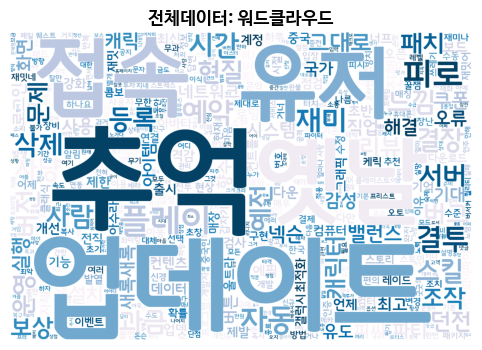

In [ ]:
## 워드클라우드(빈도분석)(4)
# 분석 결과 확인

# 옵션 설정
font_path = "/content/drive/MyDrive/3. Research/[기업] 분석 과제/네오플 트렌드 분석/Data/font/GodoM.ttf"
wc = WordCloud(width = 1200, height = 800,                                                                 # 크기 설정
               background_color = "white",                                                                 # 배경색 설정
               random_state = 0,                                                                           # 출력 상태 설정
               font_path = font_path,                                                                      # 폰트 설정
               colormap = "PuBu",                                                                          # 글자 색상 설정
               max_words = 500)                                                                            # 단어 개수 설정

# 시각화
plt.imshow(wc.generate_from_frequencies(MDunpa_reviews_words))                                             # 결과 도출
plt.title("전체데이터: 워드클라우드", fontsize=13, fontweight ="bold")                                     # 그래프 제목 설정
plt.axis("off")                                                                                            # 프레임 제거(결과만 출력)
plt.show()

In [ ]:
## 전체 데이터를 대상으로 빈도분석을 수행한 결과, 2개 사실을 추론했다.
# ①유저들은 던파 원장에 대한 추억 혹은 그리움으로 던파 모바일을 플레이했을 것이라 예상된다.
# ②특정 단어를 통해 던파의 컨셉을 추론했다(예시, 결장, 결투, 현질, 보안(서버, 해킹, 삭제 등))

___

### **네트워크분석**

In [ ]:
## 네트워크분석(1)
# 불용어사전의 단어를 제거하여 리스트 재정의

sample_data01_list = []
sample_data02_list = []
semi_Stop_Word_dic = [""]   # 불필요 단어 모음

for one_list in tqdm(sample_data03_list02):
  for word in one_list:
    if len(word)<= 1 or word in semi_Stop_Word_dic:
      pass
    else:
      sample_data01_list.append(word)
  if len(sample_data01_list) == 0:
    pass
  else:
    sample_data02_list.append(sample_data01_list)
  sample_data01_list = []

100%|██████████| 10653/10653 [00:00<00:00, 411746.63it/s]


In [ ]:
## 네트워크분석(2)
# 연관성분석을 통해 지지도 측정

result = (list(apriori(sample_data02_list, min_support=0.01)))
df = pd.DataFrame(result)
df["length"] = df["items"].apply(lambda x: len(x))
df = df[(df["length"] == 2) & (df["support"]>=0.01)].sort_values(by = "support", ascending = False)

print(df.shape)
df.head(10)

(21, 4)


,items,support,ordered_statistics,length
96,"(게임, 모바일)",0.0399,"[((), (게임, 모바일), 0.03986507206378412, 1.0), ((...",2
106,"(던파, 모바일)",0.0298,"[((), (던파, 모바일), 0.029847694981089645, 1.0), (...",2
103,"(추억, 게임)",0.0233,"[((), (추억, 게임), 0.023305734437289175, 1.0), ((...",2
110,"(사전, 예약)",0.0230,"[((), (사전, 예약), 0.022999080036798528, 1.0), ((...",2
95,"(던파, 게임)",0.0197,"[((), (던파, 게임), 0.019728099764898293, 1.0), ((...",2
114,"(업데이트, 하라)",0.0189,"[((), (업데이트, 하라), 0.018910354696923235, 1.0), ...",2
99,"(게임, 유저)",0.0188,"[((), (게임, 유저), 0.01880813656342635, 1.0), ((게...",2
98,"(업데이트, 게임)",0.0160,"[((), (업데이트, 게임), 0.01604824695901053, 1.0), (...",2
109,"(자동, 사냥)",0.0145,"[((), (자동, 사냥), 0.014514974956557293, 1.0), ((...",2
108,"(유저, 모바일)",0.0145,"[((), (유저, 모바일), 0.014514974956557293, 1.0), (...",2


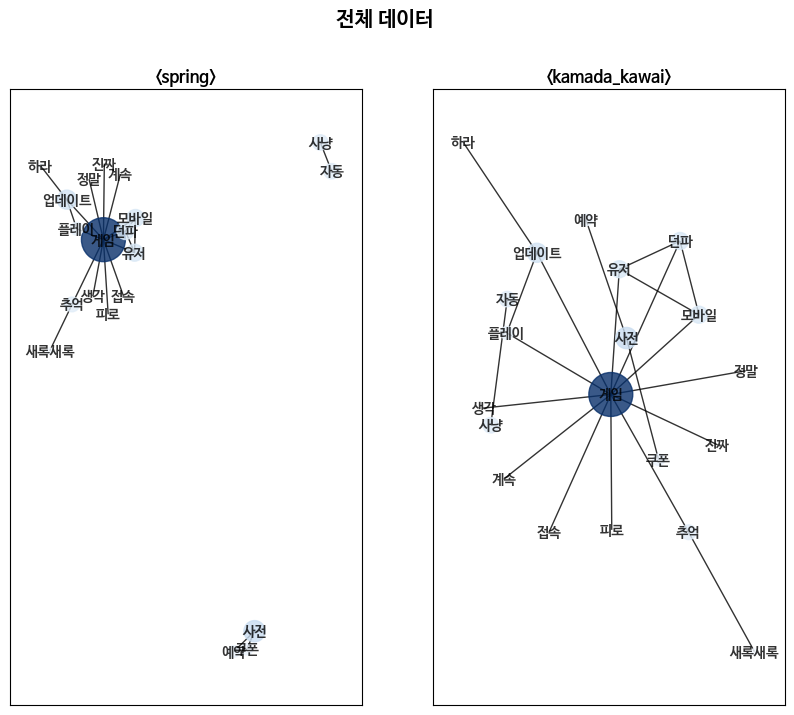

In [ ]:
## 네트워크분석(3)
# 네트워크 분석을 위해 레이아웃타입 spring_layout, kamada_kawai_layout으로 출력

# 옵션 설정
f, axes = plt.subplots(1, 2)
f.set_size_inches((10, 8))

# 입력값 정의
G = nx.Graph()                                                      # 네트워크 정의
ar = (df["items"])                                                  # 연관성 items 변수 정의
G.add_edges_from(ar)                                                # 노드 추가 설정
pr = nx.pagerank(G)                                                 # 노드 순위결정
nsize = np.array([v for v in pr.values()])
nsize = 1000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))     # 노트 크기 설정

# 레이아웃 타입 설정
layouts = {'spring': nx.spring_layout(G),                           # 반복적인 시뮬레이션으로 중심과 scale을 재구성
           'kamada_kawai':nx.kamada_kawai_layout(G)}                # 중간을 중심으로 구성


# 시각화
plt.suptitle('전체 데이터', fontsize=15, fontweight ="bold")
for i, kv in enumerate(layouts.items()):
  # 레리아웃 타입, 지지도값, 인덱스 위치
  title, pos, ax = kv[0], kv[1], axes[i]
  nx.draw_networkx(G,
                   font_family = "NanumBarunGothic",    # 노트 폰트 설정
                   pos = kv[1],                         # 레이아웃 타입 설정
                   node_size   = nsize,                 # 노트 크기 설정
                   node_color  = list(pr.values()),     # 노드 크기에 따른 색상 정도 설정
                   cmap        = plt.cm.Blues,          # 노트 색상 설정
                   font_size   = 10,                    # 폰트 크기 설정
                   font_color  = 'k',                   # 폰드 색상 설정
                   font_weight = "bold",                # 폰트 굵기 설정
                   alpha       = 0.8,                   # 폰트 투명도 설정
                   ax=ax)
  ax.set_title("<{}>".format(title), fontsize=12, fontweight ="bold")  # 그래프 제목 설정
  ax.axis('on')
plt.show()

In [ ]:
## 전체 데이터를 대상으로 네트워크분석을 수행한 결과, 아래와 같은 사실을 예측했다.
# ①현재 수동사냥 형태로 플레이 가능한데, '자동' 키워드가 연관성이 되는 것을 볼 때 자동사냥에 대한 니즈가 존재할 것으로 예상된다.
# ②'사전' 단어에 '예약/쿠폰' 관련 단어가 존재하는 것을 볼 때 고객들의 관심도가 존재할 것이라 예상된다.
# ③'추억/새록새록' 단어 관계성을 볼 때 던파 원작에 대한 추억적 요인들이 작극적이었을 것으로 예상된다.
# ④'게임/플레이/업데이트/하라' 단어를 볼 때 플레이 자체에 대한 불만족스러운 요인이 존재하여 업데이트르르 요청했을 것이라 예상된다.

In [ ]:
# 데이터 저장
#MDunpa_df04.to_csv('/content/drive/MyDrive/3. Research/[기업] 분석 과제/네오플 트렌드 분석/Data/Fianl_Review_Dataset_05.csv')

___